In [1]:
!pip install albumentations > /dev/null
!git clone https://github.com/qubvel/efficientnet.git

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Cloning into 'efficientnet'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 116 (delta 62), reused 75 (delta 35), pack-reused 0
Receiving objects: 100% (116/116), 764.50 KiB | 0 bytes/s, done.
Resolving deltas: 100% (62/62), done.


In [2]:
import os
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
from PIL import Image
import cv2

from keras.applications.resnet50 import preprocess_input

from keras.applications.imagenet_utils import decode_predictions

from efficientnet import EfficientNetB0,EfficientNetB3
from efficientnet import center_crop_and_resize, preprocess_input
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


In [3]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels,augmentations, batch_size=32, dim=(32,32,32), n_channels=3,
                 n_classes=5, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.path = '../input/game-of-deep-learning-ship-datasets/train/images/'
        self.augment = augmentations
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.data_generation(list_IDs_temp)

        return np.stack([
            self.augment(image=x)["image"] for x in X
        ], axis=0), np.array(y)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         print(X.shape,self.dim)
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            im = np.array(Image.open(self.path+ID))
            if len(im.shape)==2:
                im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)

#             # Resize sample
            X[i,] = cv2.resize(im,(self.dim[0],self.dim[1]))

            # Store class
            y[i] = self.labels.loc[ID].category

#         print(X.shape)
        return np.uint8(X), keras.utils.to_categorical(y, num_classes=self.n_classes)

In [4]:
import cv2
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,OneOf,
    ToFloat, ShiftScaleRotate,GridDistortion, ElasticTransform, JpegCompression, HueSaturationValue,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise,CenterCrop,
    IAAAdditiveGaussianNoise,GaussNoise,Cutout
)

AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=1.2, p=0.5),
    HueSaturationValue(hue_shift_limit=5, sat_shift_limit=20,
                       val_shift_limit=10, p=.5),
#     CenterCrop(height=128, width=128, p=0.5),
    Cutout(p=0.5),
    OneOf([
            MotionBlur(p=0.2),
            MedianBlur(blur_limit=3, p=0.1),
            Blur(blur_limit=3, p=0.1),
        ], p=0.3),
    OneOf([
            IAAAdditiveGaussianNoise(),
            GaussNoise(),
        ], p=0.2),
    # CLAHE(p=1.0, clip_limit=2.0),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.5), 
    ToFloat(max_value=255)
],p=1)


AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
],p=1)

In [5]:
class TestDataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs,augmentations, batch_size=32, dim=(32,32,32), n_channels=3,
                 n_classes=5, shuffle=False,flip=False,path=None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        if path is not None:
            self.path = path
        else:
            self.path = '../input/avgameofdltestjpg/test-jpg/test-jpg/'
        self.on_epoch_end()
        self.augment = augmentations
        self.flip = flip
#         print(len(self.list_IDs))

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'

        indexes = self.indexes[index*self.batch_size:min((index+1)*self.batch_size,len(self.list_IDs))]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self.data_generation(list_IDs_temp)
        
        return np.stack([
                    self.augment(image=x)["image"] for x in X
                ], axis=0)
#         return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))

    def data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(list_IDs_temp), *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            im = np.array(Image.open(self.path+ID))
            if len(im.shape)==2:
                im = cv2.cvtColor(im,cv2.COLOR_GRAY2RGB)

            # Resize sample
            if self.flip:
                X[i,] = np.fliplr(cv2.resize(im,(self.dim[0],self.dim[1])))
            else:
                X[i,] = cv2.resize(im,(self.dim[0],self.dim[1]))


        return np.uint8(X)

In [6]:
train = pd.read_csv('../input/game-of-deep-learning-ship-datasets/train/train.csv')
train['category'] = train['category'] - 1

# Parameters
params = {'dim': (128,128),
          'batch_size': 32,
          'n_classes': 5,
          'n_channels': 3,
          'shuffle': True}

In [7]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Maximum
from keras.layers import ZeroPadding2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import regularizers
from keras.layers import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from skimage.transform import resize as imresize
from tqdm import tqdm


In [8]:
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
#     for layer in base_model.layers:
#         layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [9]:
def plot_loss_acc(history):
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'][1:])    
    plt.plot(history.history['val_loss'][1:])    
    plt.title('model loss')    
    plt.ylabel('val_loss')    
    plt.xlabel('epoch')    
    plt.legend(['Train','Validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['acc'][1:])
    plt.plot(history.history['val_acc'][1:])
    plt.title('Model Accuracy')
    plt.ylabel('val_acc')
    plt.xlabel('epoch')
    plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [10]:
test = pd.read_csv('../input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')

In [11]:
from keras import backend as K
import tensorflow as tf
'''
Compatible with tensorflow backend
'''
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [12]:
class SnapshotCallbackBuilder:
    def __init__(self, nb_epochs, nb_snapshots, init_lr=0.1):
        self.T = nb_epochs
        self.M = nb_snapshots
        self.alpha_zero = init_lr

    def get_callbacks(self, model_prefix='Model'):

        callback_list = [
#             callbacks.ModelCheckpoint("./keras.model",monitor='val_loss', 
#                                    mode = 'min', save_best_only=True, verbose=1),
            swa,
            callbacks.LearningRateScheduler(schedule=self._cosine_anneal_schedule)
        ]

        return callback_list

    def _cosine_anneal_schedule(self, t):
        cos_inner = np.pi * (t % (self.T // self.M))  # t - 1 is used when t has 1-based indexing.
        cos_inner /= self.T // self.M
        cos_out = np.cos(cos_inner) + 1
        return float(self.alpha_zero / 2 * cos_out)

import keras.callbacks as callbacks

class SWA(keras.callbacks.Callback):
    
    def __init__(self, filepath, swa_epoch):
        super(SWA, self).__init__()
        self.filepath = filepath
        self.swa_epoch = swa_epoch 
    
    def on_train_begin(self, logs=None):
        self.nb_epoch = self.params['epochs']
        print('Stochastic weight averaging selected for last {} epochs.'
              .format(self.nb_epoch - self.swa_epoch))
        
    def on_epoch_end(self, epoch, logs=None):
        
        if epoch == self.swa_epoch:
            self.swa_weights = self.model.get_weights()
            
        elif epoch > self.swa_epoch:    
            for i in range(len(self.swa_weights)):
                self.swa_weights[i] = (self.swa_weights[i] * 
                    (epoch - self.swa_epoch) + self.model.get_weights()[i])/((epoch - self.swa_epoch)  + 1)  

        else:
            pass
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.swa_weights)
        print('Final model parameters set to stochastic weight average.')
        self.model.save_weights(self.filepath)
        print('Final stochastic averaged weights saved to file.')

In [13]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        pt_1 = K.clip(pt_1, 1e-3, .999)
        pt_0 = K.clip(pt_0, 1e-3, .999)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

**************************************************
Fold 1
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Shapes are always computed; don't use the compute_shapes as it has no effect.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
16719872/16717576 [==============================] - 0s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Stochastic weight averaging selected for last 3 epochs.
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


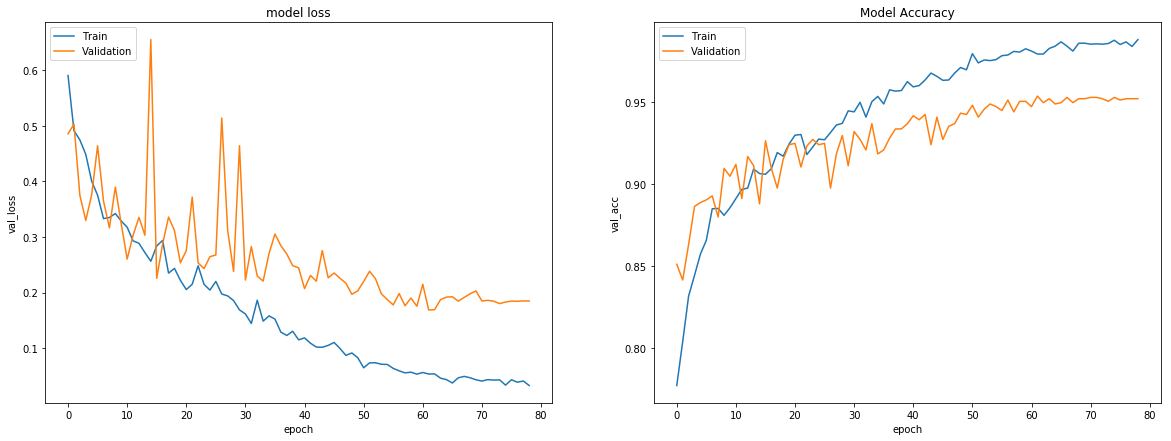

**************************************************
Fold 2
Stochastic weight averaging selected for last 3 epochs.
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


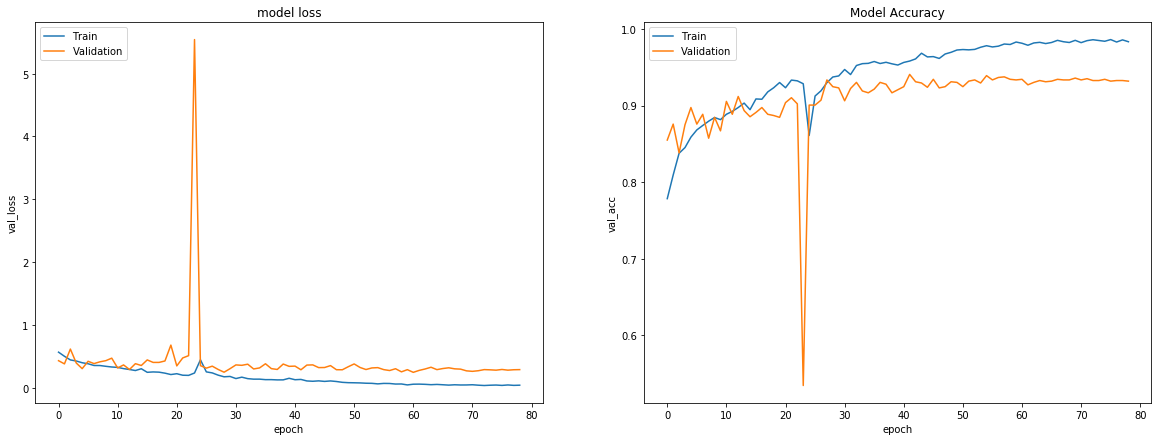

**************************************************
Fold 3
Stochastic weight averaging selected for last 3 epochs.
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


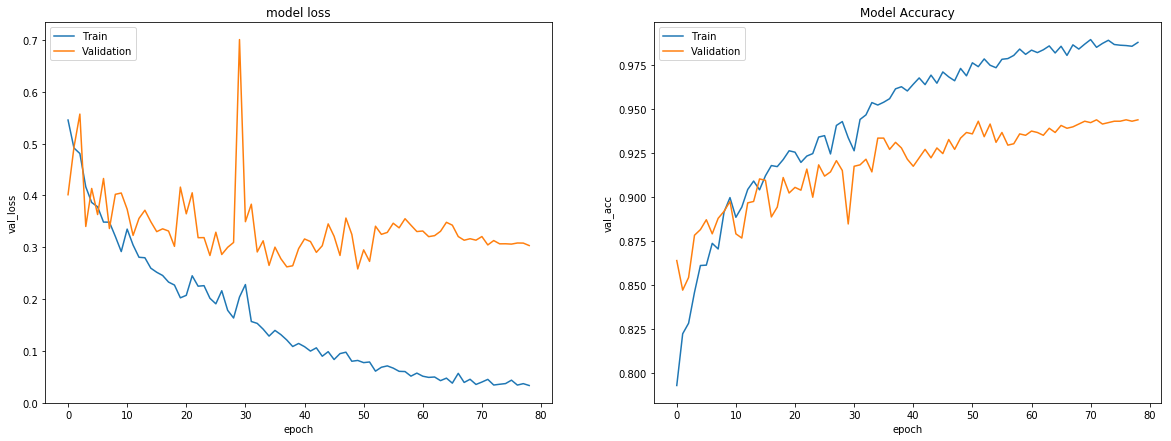

**************************************************
Fold 4
Stochastic weight averaging selected for last 3 epochs.
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


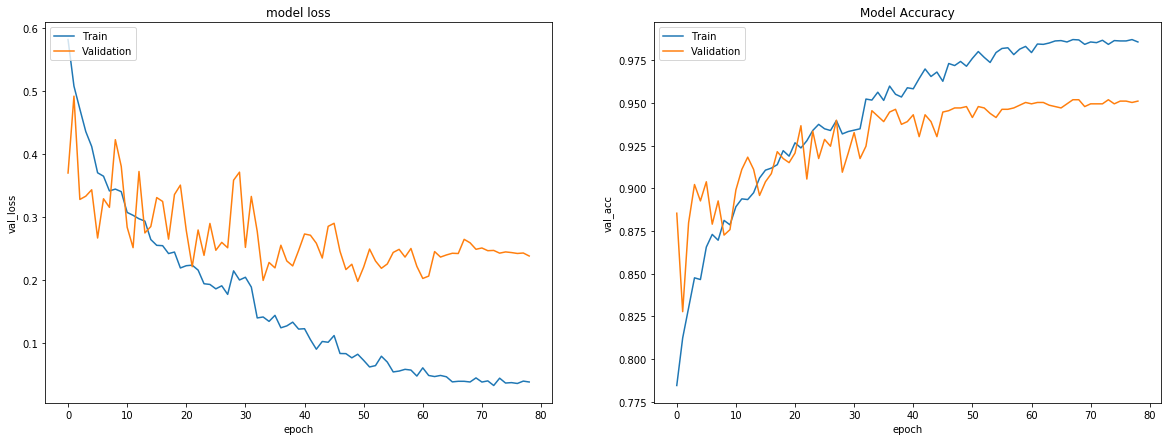

**************************************************
Fold 5
Stochastic weight averaging selected for last 3 epochs.
Final model parameters set to stochastic weight average.
Final stochastic averaged weights saved to file.


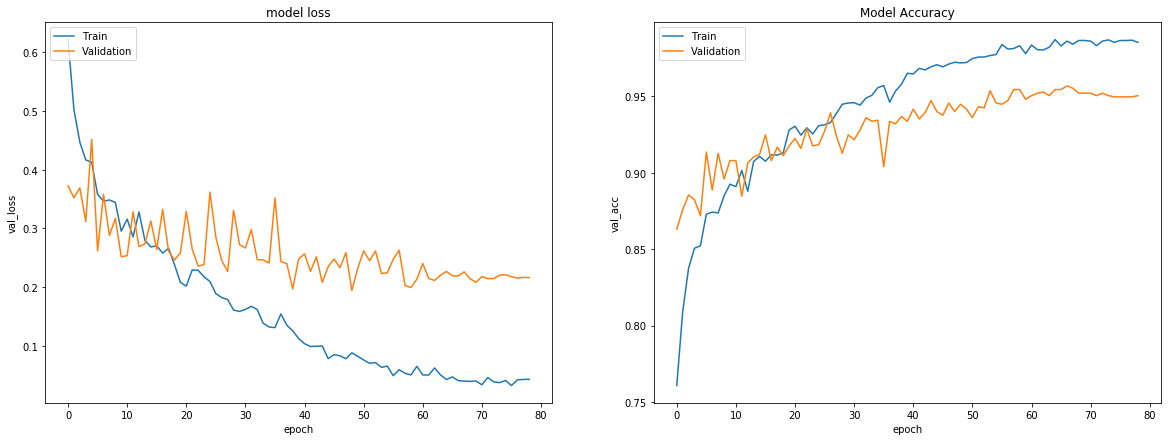

In [14]:
skf = StratifiedKFold(5)
all_preds,fold = [],1

HEIGHT = 128
WIDTH = 128

input_shape=(HEIGHT, WIDTH, 3)

FC_LAYERS = [1024]
dropout = 0.25
epochs = 80
swa = SWA('./keras_swa.model',epochs-3)

oof_preds = np.zeros((len(train), 6))

for train_indices,val_indices in skf.split(train.image.values,train.category.values):
    
    print('*'*50)
    print('Fold',fold)
    fold += 1
    
    # Datasets
    partition_train = train.loc[train_indices].image.values
    labels_train = train.loc[train_indices].set_index('image')
    
    partition_valid = train.loc[val_indices].image.values
    labels_valid = train.loc[val_indices].set_index('image')

    # Generators
    training_generator = DataGenerator(partition_train, labels_train,augmentations=AUGMENTATIONS_TRAIN, **params)
    validation_generator = DataGenerator(partition_valid,labels_valid,augmentations=AUGMENTATIONS_TEST, **params)
    
    base_model = EfficientNetB0(weights='imagenet',
                                include_top=False,
                                input_shape=(HEIGHT, WIDTH, 3))

    finetune_model = build_finetune_model(base_model, 
                                          dropout=dropout, 
                                          fc_layers=FC_LAYERS, 
                                          num_classes=5)
    
    finetune_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    snapshot = SnapshotCallbackBuilder(nb_epochs=epochs,nb_snapshots=1,init_lr=1e-3)


    history = finetune_model.fit_generator(generator=training_generator,
                                            validation_data=validation_generator,
                                            use_multiprocessing=True,
                                            workers=8,epochs=epochs,verbose=0,callbacks=snapshot.get_callbacks())
    
    finetune_model.load_weights('./keras_swa.model')
    
    try:
        plot_loss_acc(history)
    except:
        print('no plot')
    
    test_generator = TestDataGenerator(test.image.values,augmentations=AUGMENTATIONS_TEST, **params)
    test_generator_flipped = TestDataGenerator(test.image.values,augmentations=AUGMENTATIONS_TEST, **params,
                                               flip=True)
    
    validation_generator = TestDataGenerator(partition_valid,augmentations=AUGMENTATIONS_TEST, **params,
                                            path='../input/game-of-deep-learning-ship-datasets/train/images/')
    validation_generator_flipped = TestDataGenerator(partition_valid,augmentations=AUGMENTATIONS_TEST,
                                             **params,flip=True,
                                                path='../input/game-of-deep-learning-ship-datasets/train/images/')
    preds1 = []
    for im in validation_generator:    
        preds1.extend(finetune_model.predict(im))
        
    preds2 = []
    for im in validation_generator_flipped:    
        preds2.extend(finetune_model.predict(im))
        
    preds1 = np.array(preds1)
    preds2 = np.array(preds2)
    
    preds = (preds1 + preds2)/2
    
    oof_preds[val_indices, :5] = preds
    oof_preds[val_indices, 5] = train.loc[val_indices,'image'].map(lambda x: x[:-4])
    
    preds1 = []
    for im in test_generator:    
        preds1.extend(finetune_model.predict(im))
        
    preds2 = []
    for im in test_generator_flipped:    
        preds2.extend(finetune_model.predict(im))
        
    preds1 = np.array(preds1)
    preds2 = np.array(preds2)
    
    preds = (preds1 + preds2)/2
        
    all_preds.append(preds)

In [15]:
pd.DataFrame(oof_preds).to_csv('oof_preds.csv',index=False)

In [16]:
pd.DataFrame(oof_preds).head()

,0,1,2,3,4,5
0,1.000000e+00,4.715027e-17,2.123346e-14,2.215009e-17,4.025063e-09,2823080.0
1,1.000000e+00,6.555633e-19,3.251182e-15,2.353056e-18,6.944887e-10,2870024.0
2,2.778766e-08,1.000000e+00,2.508752e-14,8.623680e-10,2.431659e-11,2662125.0
3,4.373213e-20,4.454984e-25,1.000000e+00,2.566989e-20,6.906582e-22,2900420.0
4,1.371400e-03,9.986035e-01,4.787562e-08,4.016099e-06,2.097755e-05,2804883.0


In [17]:
preds = np.ones((2680,5))
for preds_fold in all_preds:
    preds = preds*preds_fold


In [18]:
preds = preds**(1/skf.n_splits)
test = pd.read_csv('../input/game-of-deep-learning-ship-datasets/test_ApKoW4T.csv')
labelled_preds = np.argmax(preds,1)+1
# fnames = [f.name for f in learn.data.test_ds.items]
fnames = test.image.values
df = pd.DataFrame({'image':fnames, 'category':labelled_preds}, columns=['image', 'category'])
df.to_csv('submission_gm.csv', index=False)
df.head()

,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [19]:
df.tail()

,image,category
2675,950995.jpg,4
2676,951046.jpg,4
2677,951323.jpg,4
2678,952113.jpg,4
2679,953982.jpg,4


In [20]:
df['class1_prob'] = preds[:,0]
df['class2_prob'] = preds[:,1]
df['class3_prob'] = preds[:,2]
df['class4_prob'] = preds[:,3]
df['class5_prob'] = preds[:,4]
df.to_csv('raw_prob.csv', index=False)

In [21]:
!rm -rf efficientnet/